Test registration of small subset of public EMPIAR 12193 dataset

In [267]:
import matplotlib.pyplot as plt
import numpy as np
from ome_zarr.io import parse_url
from ome_zarr.reader import Reader
import os.path
from skimage.feature import match_descriptors, plot_matched_features, ORB
from skimage.filters import gaussian
from skimage.measure import ransac
from skimage.transform import EuclideanTransform

Load small subset of stitched slices

(2397, 2388) 2392.5 uint16


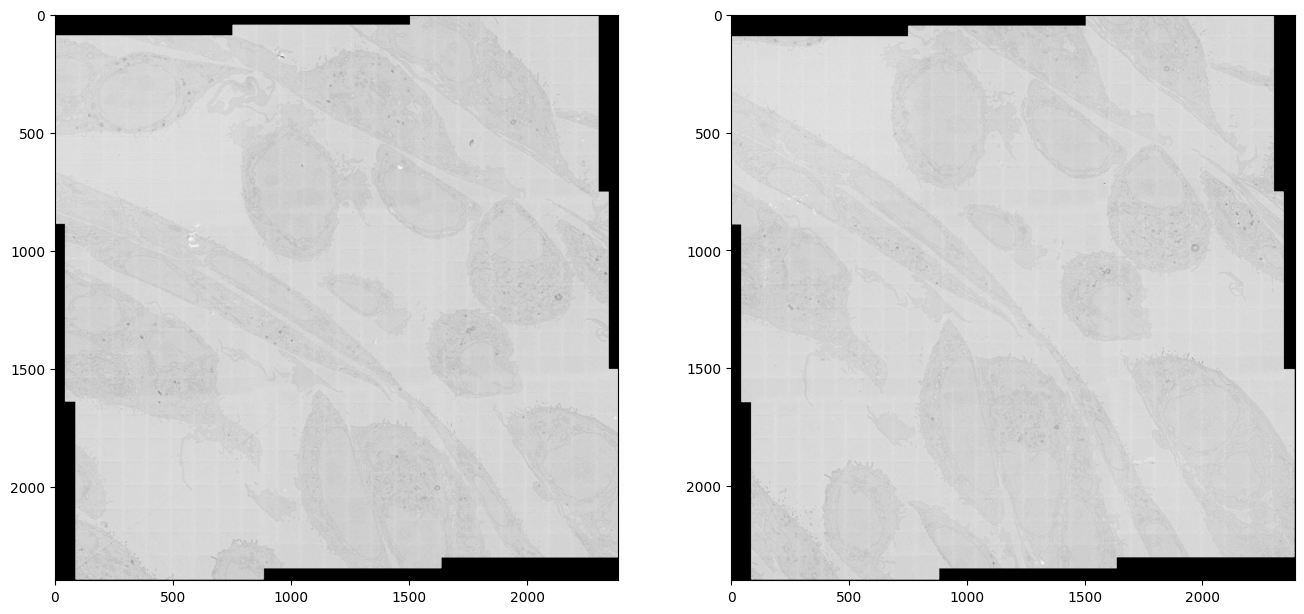

In [268]:
base_dir = 'data/12193/stitched'
filenames = ['S001.ome.zarr', 'S002.ome.zarr']
level = 0

images = []
for filename in filenames:
    reader = Reader(parse_url(os.path.join(base_dir, filename), mode="r"))
    nodes = list(reader())
    image_node = nodes[0]
    images.append(image_node.data[level].squeeze())

mean_size = np.linalg.norm(images[0].shape) / np.sqrt(2)

print(images[0].shape, f'{mean_size:0.1f}', images[0].dtype)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(images[0], cmap='gray')
ax2.imshow(images[1], cmap='gray')
plt.show()


Pre-process images: normalize and downsample

Not using downsampling appears to give very poor results

(2397, 2388) float32


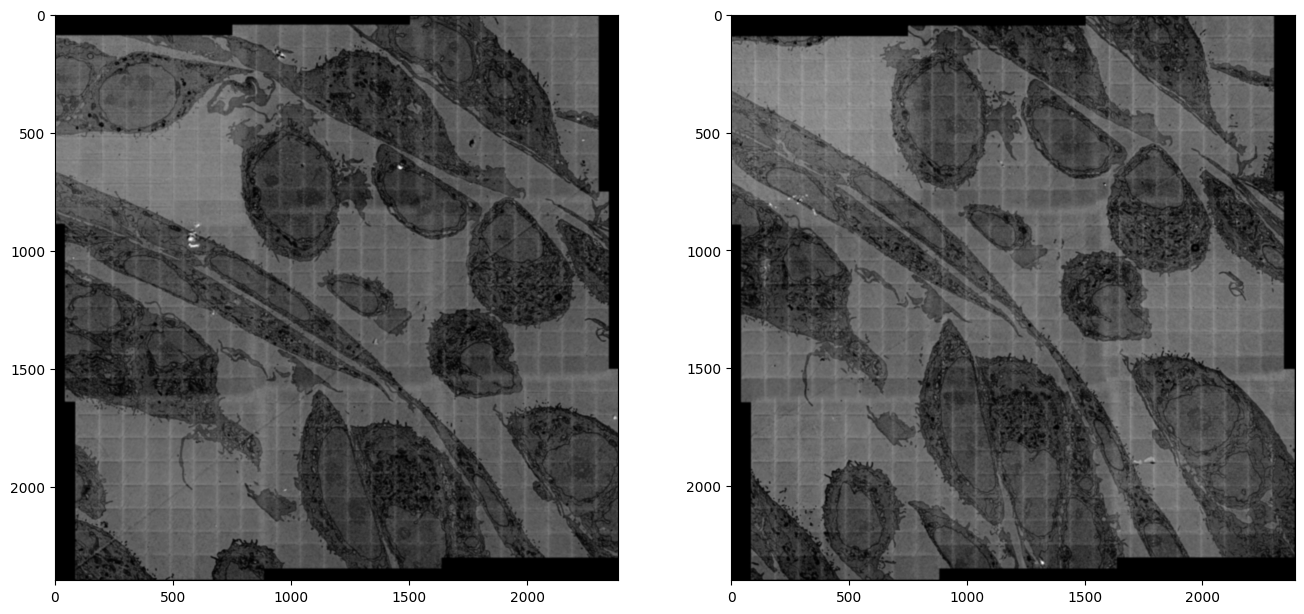

In [269]:
sigma = max(1, mean_size / 1000)

images2 = []
source_type = images[0].dtype
maxval = 2 ** (8 * source_type.itemsize) - 1
for image in images:
    float_image = image / np.float32(maxval)
    minimum = np.mean(float_image, dtype=np.float32)
    range = np.std(float_image, dtype=np.float32)
    norm_image = np.clip((float_image - minimum) / range, 0, 1)
    filtered_image = gaussian(norm_image, sigma=sigma)
    images2.append(filtered_image)

print(images2[0].shape, images2[0].dtype)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.imshow(images2[0], cmap='gray')
ax2.imshow(images2[1], cmap='gray')
plt.show()

Feature extraction

Prefer using ORB as Open method.
Note SIFT performs extremely poor compared to ORB in this case.

In [270]:
downscale = 2 if mean_size > 4000 else np.sqrt(2)

feature_model = ORB(n_keypoints=5000, downscale=downscale)

points = []
descs = []
for image in images2:
    feature_model.detect_and_extract(image)
    points.append(feature_model.keypoints)     # output order is y,x
    descs.append(feature_model.descriptors)

print('# detected keypoints', [len(points1) for points1 in points])

# detected keypoints [5000, 5000]


Feature matching

matching is using Lowe ratio

threshold is used for RANSAC to filter outliers

In [278]:
min_samples = 5
threshold = mean_size * 0.05
lowe_ratio = 0.92

matches = match_descriptors(descs[0], descs[1], cross_check=True, max_ratio=lowe_ratio)
print('# matches', len(matches))

points1, points2 = points
match_points1 = np.array([points1[match[0]] for match in matches])
match_points2 = np.array([points2[match[1]] for match in matches])
transform, inliers = ransac((match_points1, match_points2), EuclideanTransform, min_samples=min_samples,
                                   residual_threshold=threshold, max_trials=1000)

print('# inliers', np.sum(inliers))
print('translation', transform.translation, 'rotation', transform.rotation)

# matches 390
# inliers 71
translation [-404.11687015  -38.04755342] rotation -0.09551174831478813


Draw matching keypoints, inliers in green color

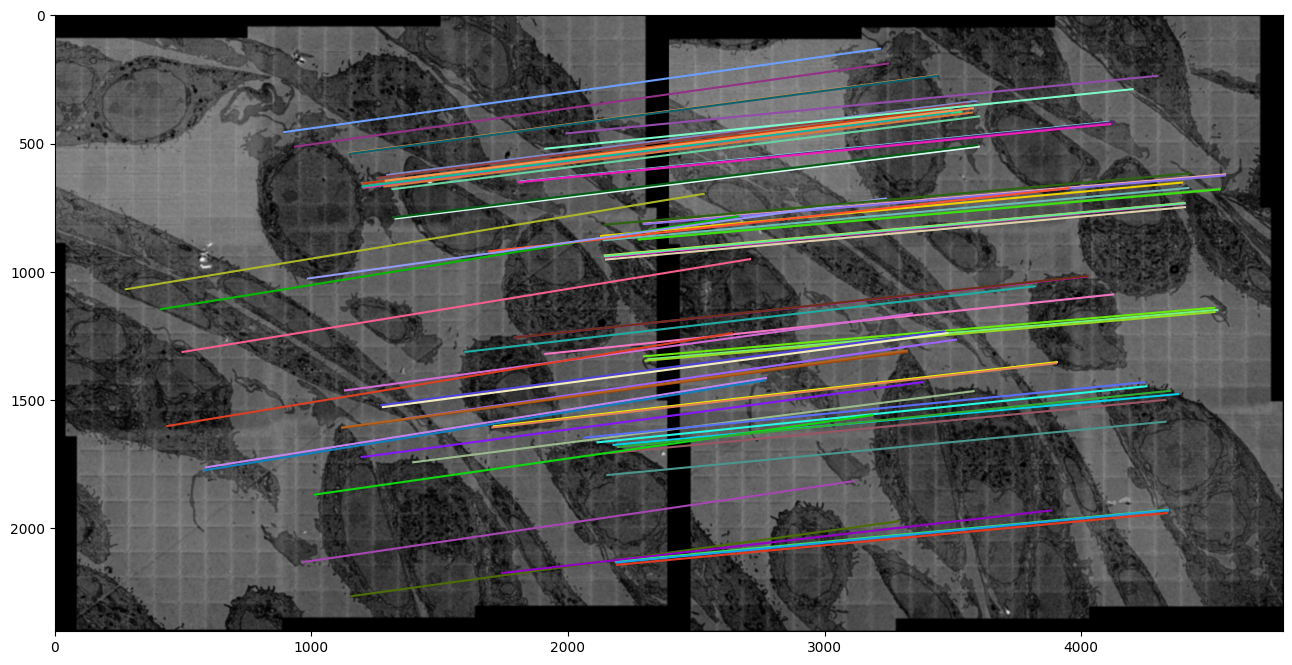

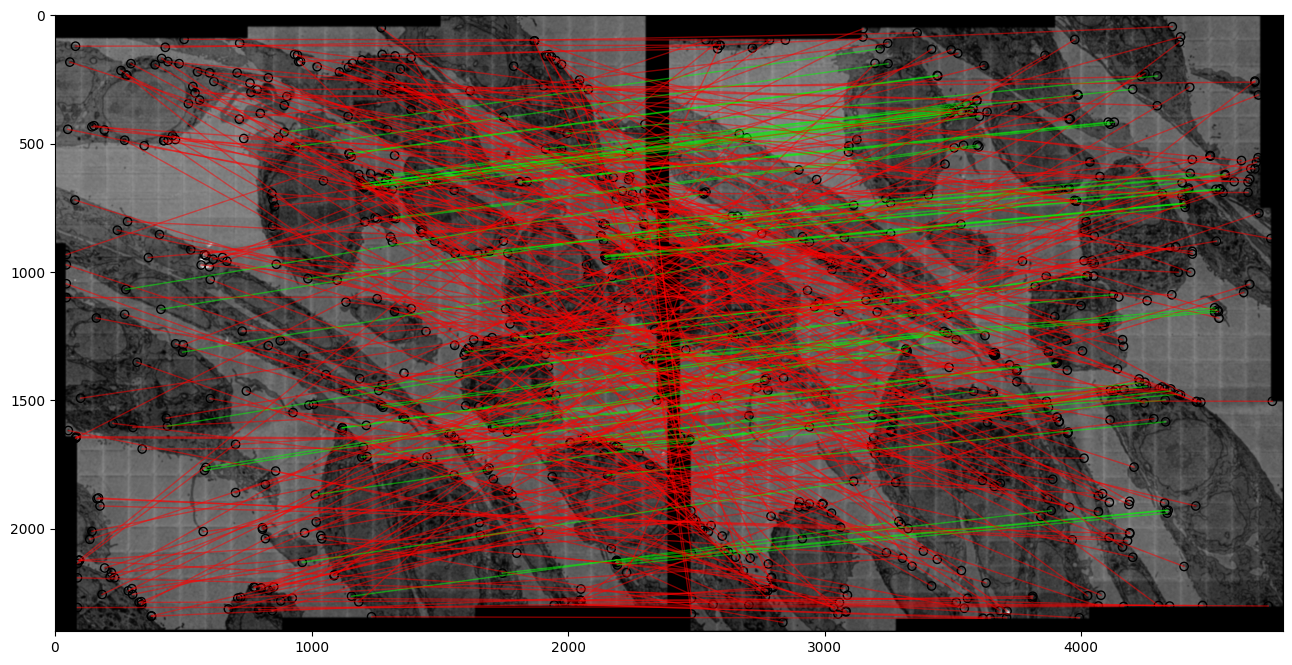

In [279]:
out_images = images2
matches_inliers = matches[inliers]

fig, ax = plt.subplots(figsize=(16,8))
plot_matched_features(
    out_images[0],
    out_images[1],
    keypoints0=points1,
    keypoints1=points2,
    matches=matches_inliers,
    ax=ax,
    only_matches=True,
)
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
shape = np.max([image.shape for image in images], axis=0)
image = np.concatenate([
    np.pad(out_images[0], ((0, shape[0] - out_images[0].shape[0]), (0, shape[1] - out_images[0].shape[1]))),
    np.pad(out_images[1], ((0, shape[0] - out_images[1].shape[0]), (0, shape[1] - out_images[1].shape[1])))
], axis=1)
offset2 = [0, shape[1]]
ax.imshow(image, cmap='gray')

keypoints_color = 'black'
ax.scatter(
    match_points1[:, 1],
    match_points1[:, 0],
    facecolors='none',
    edgecolors=keypoints_color,
)
ax.scatter(
    match_points2[:, 1] + offset2[1],
    match_points2[:, 0] + offset2[0],
    facecolors='none',
    edgecolors=keypoints_color,
)

for i, match in enumerate(matches):
    color = 'lime' if inliers[i] else 'red'
    index1, index2 = match
    ax.plot(
        (points1[index1, 1], points2[index2, 1] + offset2[1]),
        (points1[index1, 0], points2[index2, 0] + offset2[0]),
        '-', linewidth=1, alpha=0.5, color=color,
    )

plt.show()